In [ ]:
import torch
import sys
import os
import argparse

# 1. 导入必要的库和你训练时用的trainer/model定义
from dassl.config import get_cfg_default
from dassl.data.transforms import build_transform
from dassl.utils import setup_logger
from dassl.data.data_manager import build_data_loader
from dassl.data.datasets import DATASET_REGISTRY
from train import setup_cfg
import random

In [62]:
def _prepare_args():
    args = argparse.Namespace()

    defaults = {
        "config_file": "",
        "dataset_config_file": "",
        "root": "",
        "output_dir": "",
        "resume": "",
        "seed": None,
        "source_domains": None,
        "target_domains": None,
        "transforms": None,
        "trainer": "",
        "backbone": "",
        "head": "",
        "device": None,
        "eval_only": False,
        "model_dir": "",
        "load_epoch": None,
        "no_train": False,
        "best": False,
        "draw": False,
        "opts": None,
    }

    for key, value in defaults.items():
        if not hasattr(args, key) or getattr(args, key) is None:
            setattr(args, key, [] if key == "opts" else value)

    if args.opts is None:
        args.opts = []

    return args

args = _prepare_args()
# 2. 加载配置
cfg = setup_cfg(args)
# 加载你训练时用的 config 文件！这是关键，确保 DATASET.NAME 等配置正确
# BITP/vit_b16_c2_ep20_ctx2_dp9TT_ADD.yaml
# BITP/vit_b16_c2_ep20_ctx2_dp9TT_ATTEN.yaml
cfg.merge_from_file("/home/lvsl/Code/Base2new/BMIP_final_copy/configs/trainers/PromptSRC/promptsrc_rs_sgd_4.yaml") 
cfg.merge_from_file("/home/lvsl/Code/Base2new/BMIP_final_copy/configs/datasets/mlrsnet.yaml")
cfg.defrost()
# 如果需要，可以用命令行参数覆盖一些设置，如数据集路径
cfg.DATASET.ROOT = "/mnt/hdd/DATA" 
cfg.freeze()

In [ ]:
dataset_class = DATASET_REGISTRY.get(cfg.DATASET.NAME)
dataset = dataset_class(cfg) # 实例化数据集类
classnames = dataset.classnames # 获取类别名称列表
print(f"Loaded {len(classnames)} classes: {classnames[:5]}...") # 打印前几个类别确认

In [ ]:
# print(dataset)
# if hasattr(dataset, "test") and len(dataset.test) > 0:
#     sample_split = dataset.test
#     split_name = "test"
# elif hasattr(dataset, "val") and len(dataset.val) > 0:
#     sample_split = dataset.val
#     split_name = "val"
# else:
#     sample_split = dataset.train_x
#     split_name = "train"
# sample_records = sample_split[:4]
# image_paths = [record.impath for record in sample_records]
# print(f"从 {split_name} 划分中选取 {len(image_paths)} 张图片: {image_paths}")

# 指定几张图
# image_paths = ['/mnt/hdd/DATA/MLRSNet/Images/airplane/airplane_00012.jpg', '/mnt/hdd/DATA/MLRSNet/Images/basketball_court/basketball_court_00001.jpg', '/mnt/hdd/DATA/MLRSNet/Images/airplane/airplane_00034.jpg']



# --- 1. 获取数据划分 ---
if hasattr(dataset, "test") and len(dataset.test) > 0:
    sample_split = dataset.test
    split_name = "test"
elif hasattr(dataset, "val") and len(dataset.val) > 0:
    sample_split = dataset.val
    split_name = "val"
else:
    sample_split = dataset.train_x
    split_name = "train"

print(f"从 {split_name} 划分中共有 {len(sample_split)} 张图片.")

# --- 2. 按类别分组 ---
label_to_records = {}
for record in sample_split:
    label = record.label
    if label not in label_to_records:
        label_to_records[label] = []
    label_to_records[label].append(record)

all_class_indices = list(label_to_records.keys())
print(f"该划分包含 {len(all_class_indices)} 个类别.")

# --- 3. 随机选择 8 个类别 ---
num_classes_to_select = 8
if len(all_class_indices) < num_classes_to_select:
    print(f"警告: 数据集中只有 {len(all_class_indices)} 个类别，少于请求的 {num_classes_to_select} 个。")
    selected_class_indices = all_class_indices
else:
    selected_class_indices = random.sample(all_class_indices, num_classes_to_select)

print(f"随机选中的类别索引: {selected_class_indices}")
print(f"对应类别名: {[classnames[i] for i in selected_class_indices]}")
# --- 4. 从每个选中类别中取 2 张图 ---
num_per_class = 2
selected_records = []
for label_idx in selected_class_indices:
    records = label_to_records[label_idx]
    if len(records) < num_per_class:
        print(f"  警告: 类别 '{classnames[label_idx]}' 只有 {len(records)} 张图，将全部选取。")
        selected_records.extend(records)
    else:
        sampled_records = random.sample(records, num_per_class)
        selected_records.extend(sampled_records)

print(f"✅ 总共选取了 {len(selected_records)} 张图片用于可视化。")

# --- 5. 提取图片路径 ---
image_paths = [record.impath for record in selected_records]
labels = [classnames[rec.label] for rec in selected_records]

In [64]:
# 5. 构建模型 (与 model.txt 中的 build_model 逻辑类似)
from trainers.bmip_loss import CustomCLIP, load_clip_to_cpu

clip_model = load_clip_to_cpu(cfg)
model = CustomCLIP(cfg, classnames, clip_model)

# /home/lvsl/Code/Base2new/BMIP_final_copy/output/base2new/train_base/vit_b16_c2_ep20_ctx2_dp9TT_ADD/mlrsnet/seed1
# /home/lvsl/Code/Base2new/BMIP_final_copy/output/base2new/train_base/vit_b16_c2_ep20_ctx2_dp9TT_ATTEN/mlrsnet/seed1
# model_dir = "/home/lvsl/Code/Base2new/BMIP_final_copy/output/base2new/train_base/promptsrc_rs_sgd_4/mlrsnet/seed2" # 例如: output/bmiploss/oxford_pets/RN50/best.pth.tar 所在的目
# model_file = "model.pth.tar-20" # 或者你想要加载的具体文件名
# model_path = os.path.join(model_dir, "MultiModalPromptLearner", model_file) # 假设权重保存在 MultiModalPromptLearner 下

model_path = "/home/lvsl/Code/Base2new/BMIP_final_copy/output/base2new/train_base/promptsrc_rs_sgd_4/mlrsnet/seed1/VLPromptLearner/model.pth.tar-20"
checkpoint = torch.load(model_path, map_location="cpu")
state_dict = checkpoint["state_dict"]

for k in ["prompt_learner.token_prefix", "prompt_learner.token_suffix"]:
    state_dict.pop(k, None)

model.load_state_dict(state_dict, strict=False)
model.eval()
model.to("cuda") # 或 "cpu"

CustomCLIP(
  (prompt_learner): MultiModalPromptLearner(
    (proj_t): Linear(in_features=512, out_features=768, bias=True)
    (proj_v): Linear(in_features=768, out_features=512, bias=True)
    (compound_prompts_visual): ParameterList(
        (0): Parameter containing: [torch.float32 of size 2x768 (cuda:0)]
        (1): Parameter containing: [torch.float32 of size 2x768 (cuda:0)]
        (2): Parameter containing: [torch.float32 of size 2x768 (cuda:0)]
        (3): Parameter containing: [torch.float32 of size 2x768 (cuda:0)]
        (4): Parameter containing: [torch.float32 of size 2x768 (cuda:0)]
        (5): Parameter containing: [torch.float32 of size 2x768 (cuda:0)]
        (6): Parameter containing: [torch.float32 of size 2x768 (cuda:0)]
        (7): Parameter containing: [torch.float32 of size 2x768 (cuda:0)]
    )
    (single_layer_v): Linear(in_features=768, out_features=512, bias=True)
    (exchange_layer_v): Linear(in_features=1536, out_features=768, bias=True)
    (compoun

In [ ]:
# 7. 准备你的几张图片
from PIL import Image
transform = build_transform(cfg, is_train=False) # 使用测试时的 transform

images = []
raw_images = [] # 保存原始 PIL 图像用于可视化
for p in image_paths:
    raw_img = Image.open(p).convert("RGB")
    raw_images.append(raw_img)
    idx = image_paths.index(p)
    img = transform(raw_img) # [C, H, W]
    images.append(img)
images = torch.stack(images).to("cuda") # [B, C, H, W]

In [69]:
# 9. 前向传播
with torch.no_grad():
    # 如果你没有修改 forward，它会返回 logits_1, logits_2, logits_3
    # 如果你修改了 forward 返回 intermediates，它会返回 (logits_1, logits_2, logits_3, intermediates)
    logits_1, logits_2, logits_3, intermediates = model(images) 
    # 或者 (logits_1, logits_2, logits_3, intermediates) = model(images)

    # 获取预测结果
    pred_3 = logits_3.argmax(dim=1) # 选择 logits_3 的预测
    predicted_classes = [classnames[i] for i in pred_3.cpu().numpy()]
    print(f"Predictions: {predicted_classes}")

# 10. 可视化中间结果 (如果修改了 forward)

# === 可视化 ===
# confidence = intermediates["confidence"]  # [B, 196]
# attn_v2t = intermediates["attn_v2t"]       # [B, M, 196]

# print("Confidence shape:", confidence.shape if confidence is not None else None)
# print("Attention V2T shape:", attn_v2t.shape)

# # 用 matplotlib 可视化第一张图的 confidence
# if confidence is not None:
#     import matplotlib.pyplot as plt
#     conf_map = confidence[0].view(14, 14).cpu().numpy()  # ViT-B/16 => 14x14 patches
#     # plt.imshow(conf_map, cmap="hot")
#     # plt.colorbar()
#     # plt.title("Patch Confidence (Image 0)")
#     # plt.savefig("confidence_vis.png")
#     # plt.show()
#     # 创建子图
#     fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

#     # 显示原始图像
#     ax1.imshow(raw_images[0])
#     ax1.set_title(f'Original Image 0\n(Predicted: {predicted_classes[0]})')
#     ax1.axis('off') # 关闭坐标轴

#     # 显示 Confidence 热力图
#     im = ax2.imshow(conf_map, cmap="hot") # interpolation 使热力图更平滑
#     ax2.set_title('Patch Confidence Map (Image 0)')
#     ax2.axis('off') # 关闭坐标轴
#     # 添加颜色条
#     plt.colorbar(im, ax=ax2)

#     plt.tight_layout() # 调整子图间距
#     plt.show()

# === 可视化：每张图片一行，显示原图 + confidence 热力图 ===
import numpy as np
confidence = intermediates["confidence"]
if confidence is not None:
    import matplotlib.pyplot as plt
    from math import ceil

    num_images = len(raw_images)
    patch_grid_size = int(confidence.shape[1] ** 0.5)  # 假设是 ViT 且为 square (e.g., 196 → 14)

    # 创建子图：num_images 行，2 列
    fig, axes = plt.subplots(num_images, 2, figsize=(8, 4 * num_images))
    
    # 如果只有一张图，axes 不是二维数组，需特殊处理
    if num_images == 1:
        axes = axes[np.newaxis, :]  # 变成 (1, 2)

    for i in range(num_images):
        # 原图
        axes[i, 0].imshow(raw_images[i])
        axes[i, 0].set_title(f'Original Image {i}\n(Label: {labels[i]})')
        axes[i, 0].axis('off')

        # Confidence 热力图
        conf_map = confidence[i].view(patch_grid_size, patch_grid_size).cpu().numpy()
        im = axes[i, 1].imshow(conf_map, cmap="hot")
        axes[i, 1].set_title(f'Patch Confidence (Image {i})\n(Predicted: {predicted_classes[i]})')
        axes[i, 1].axis('off')
        # 添加颜色条（每行一个）
        fig.colorbar(im, ax=axes[i, 1], fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()
else:
    print("Confidence is None. Make sure LOSS_METHOD is 'contrast' and forward returns intermediates.")


In [66]:
attn_v2t = intermediates["attn_v2t"]
attn_t2v = intermediates["attn_t2v"]
print(attn_v2t.shape)
print(attn_t2v.shape)
# 46类，196块
# torch.Size([4, 46, 196])
# torch.Size([4, 196, 46])
# 1. 选择第0张图片
img_idx = 0
# 2. 选择第69个 patch (注意索引从0开始，所以是68)
patch_idx = 185

# 3. 获取第0张图，第69个patch对所有类别的attention [M]
patch_attn = attn_v2t[img_idx, :, patch_idx]  # [46]

# 4. 找到前5个最高的attention值及其索引
topk_values, topk_indices = torch.topk(patch_attn, k=40, dim=0, largest=True, sorted=True)

# 5. 将索引转换为类别名称
topk_classnames = [classnames[idx] for idx in topk_indices.cpu().numpy()]

# 6. 打印结果
print(f"图片 {img_idx} 的 patch {patch_idx+1} (索引{patch_idx}) 的 top-5 相关类别:")
for i, (cls_name, attn_val) in enumerate(zip(topk_classnames, topk_values.cpu().numpy())):
    print(f"  {i+1}. {cls_name}: {attn_val:.4f}")

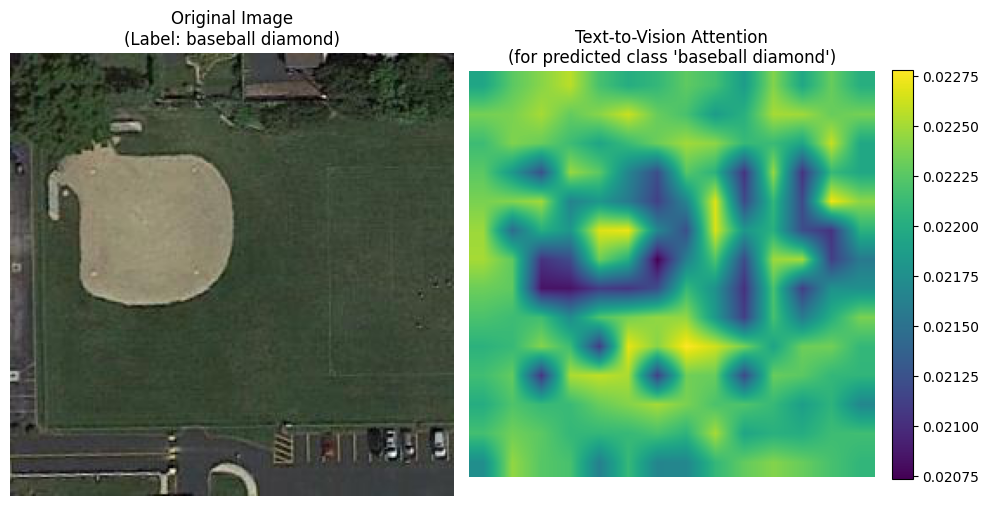

In [67]:
import matplotlib.pyplot as plt

# 假设你已经有了以下变量：
# - attn_t2v: torch.Tensor, shape [B, N, M] (e.g., [4, 196, 46])
# - logits_3: torch.Tensor, shape [B, M]
# - raw_images: list of PIL.Image, length = B
# - classnames: list of str, length = M

# 1. 选择第0张图片
img_idx = 1

# 2. 获取第0张图片的预测类别索引
pred_idx = logits_3[img_idx].argmax().item()  # int
pred_classname = classnames[pred_idx]

print(f"第 {img_idx} 张图片的预测类别: {pred_classname} (索引: {pred_idx})")

# 3. 提取第0张图对预测类别的 attention map (shape [N])
attn_map = attn_t2v[img_idx, :, pred_idx]  # [196]

# 4. reshape 成 spatial grid (e.g., 14x14 for ViT-B/16)
num_patches = attn_map.shape[0]
grid_size = int(num_patches ** 0.5)
assert grid_size * grid_size == num_patches, f"Patch count {num_patches} is not a perfect square!"

attn_map_reshaped = attn_map.view(grid_size, grid_size).cpu().numpy()  # [14, 14]

# 5. 可视化
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# 原图
ax1.imshow(raw_images[img_idx])
ax1.set_title(f"Original Image\n(Label: {labels[img_idx]})")
ax1.axis('off')

# Attention 热力图
im = ax2.imshow(attn_map_reshaped, cmap="viridis", interpolation='bilinear')
ax2.set_title(f"Text-to-Vision Attention\n(for predicted class '{pred_classname}')")
ax2.axis('off')
plt.colorbar(im, ax=ax2, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

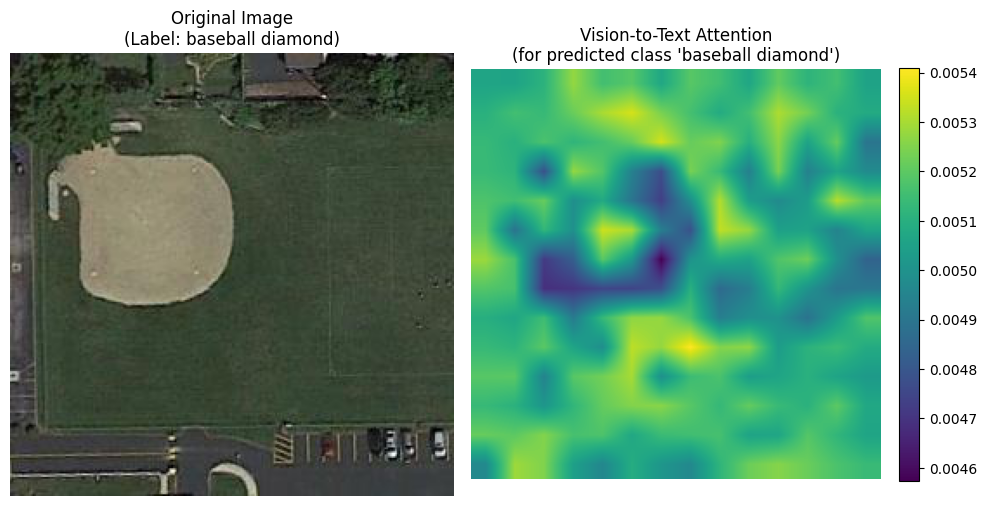

In [68]:
import matplotlib.pyplot as plt

# 假设你已经有了以下变量：
# - attn_v2t: torch.Tensor, shape [B, N, M] (e.g., [4, 196, 46])
# - logits_3: torch.Tensor, shape [B, M]
# - raw_images: list of PIL.Image, length = B
# - classnames: list of str, length = M

# 1. 选择第0张图片
img_idx = 1

# 2. 获取第0张图片的预测类别索引
pred_idx = logits_3[img_idx].argmax().item()  # int
pred_classname = classnames[pred_idx]

print(f"第 {img_idx} 张图片的预测类别: {pred_classname} (索引: {pred_idx})")

# 3. 提取第0张图对预测类别的 attention map (shape [N])
attn_map = attn_v2t[img_idx, pred_idx, :]  # [196]
# 4. reshape 成 spatial grid (e.g., 14x14 for ViT-B/16)
num_patches = attn_map.shape[0]
grid_size = int(num_patches ** 0.5)
assert grid_size * grid_size == num_patches, f"Patch count {num_patches} is not a perfect square!"

attn_map_reshaped = attn_map.view(grid_size, grid_size).cpu().numpy()  # [14, 14]

# 5. 可视化
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# 原图
ax1.imshow(raw_images[img_idx])
ax1.set_title(f"Original Image\n(Label: {labels[img_idx]})")
ax1.axis('off')

# Attention 热力图
im = ax2.imshow(attn_map_reshaped, cmap="viridis", interpolation='bilinear')
ax2.set_title(f"Vision-to-Text Attention\n(for predicted class '{pred_classname}')")
ax2.axis('off')
plt.colorbar(im, ax=ax2, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()